In [ ]:
import pandas as pd
import os
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

In [ ]:
def process_datasets(
    file_paths,
    date_columns,
    content_columns,
    output_file,
    time_included=True,
    chunk_size=100_000,
    engine='python',
    save_threshold=10_000
):
    if os.path.exists(output_file):
        os.remove(output_file)

    tweets_by_date = {}

    for i, file_path in enumerate(file_paths):
        date_column = date_columns[i] if isinstance(date_columns, list) else date_columns
        content_column = content_columns[i] if isinstance(content_columns, list) else content_columns

        total_chunks = 0
        # counting chunck in file
        for _ in pd.read_csv(
            file_path,
            usecols=[date_column, content_column],
            chunksize=chunk_size,
            engine=engine,
            on_bad_lines='skip'
        ):
            total_chunks += 1

        chunks = pd.read_csv(
            file_path,
            usecols=[date_column, content_column],
            chunksize=chunk_size,
            engine=engine,
            on_bad_lines='skip'
        )

        for chunk in tqdm(chunks, desc=f"In process {os.path.basename(file_path)}", total=total_chunks):
            chunk.rename(
                columns={date_column: 'date', content_column: 'content'},
                inplace=True
            )

            chunk["date"] = pd.to_datetime(chunk["date"], errors='coerce')

            chunk.dropna(subset=["date"], inplace=True)

            # processing a column with a date type
            if time_included:
                date_values = chunk["date"].dt.strftime('%Y-%m-%d').values
                time_values = chunk["date"].dt.strftime('%H:%M:%S').values
            else:
                date_values = chunk["date"].dt.strftime('%Y-%m-%d').values
                time_values = [None] * len(chunk)

            content_values = chunk["content"].values

            for i in range(len(chunk)):
                date = date_values[i]
                time = time_values[i]
                tweet = content_values[i]

                if date not in tweets_by_date:
                    tweets_by_date[date] = []
                tweets_by_date[date].append((time, tweet))

            if len(tweets_by_date) > save_threshold:
                save_chunk_to_file(tweets_by_date, output_file)
                tweets_by_date.clear()

    if tweets_by_date:
        save_chunk_to_file(tweets_by_date, output_file)

# data_dict: date - time, content
def save_chunk_to_file(data_dict, file_name):
    processed_data = []
    for date, tweets in tqdm(data_dict.items(), desc="Saving chunk to file"):
        tweets.sort(key=lambda x: x[0] if x[0] is not None else "23:59:59")

        #a random selection from a list of 50 tweets for the current date
        try:
            sampled_tweets = random.sample(tweets, min(50, len(tweets)))
        except ValueError as e:
            print(f"Error sampling tweets for date {date}: {e}")
            sampled_tweets = []

        for time, tweet in sampled_tweets:
            if tweet is not None and isinstance(tweet, str) and tweet.strip():
                processed_data.append([date, time, tweet])

    if processed_data:
        df = pd.DataFrame(processed_data, columns=["date", "time", "content"])


        df.to_csv(file_name, index=False)



In [ ]:
if __name__ == "__main__":
    chunksize = 100_000

    file_paths = [
        "/kaggle/input/crypto-tweets/crypto_10k_tweets_(2021_2022Nov).csv",
        "/kaggle/input/bitcoin-tweets/Bitcoin_tweets.csv",
        "/kaggle/input/bitcoin-tweets/Bitcoin_tweets_dataset_2.csv",
        "/kaggle/input/bitcoin-tweets-16m-tweets-with-sentiment-tagged/mbsa.csv"
    ]

    date_columns = ['Date', 'date', 'date', 'Date']
    content_columns = ['Content', 'text', 'text', 'text']

    process_datasets(
        file_paths=file_paths,
        date_columns=date_columns,
        content_columns=content_columns,
        output_file='combined_results.csv',
        time_included=True,
        chunk_size=chunksize,
        engine='python',
        save_threshold=10_000
    )

Processing crypto_10k_tweets_(2021_2022Nov).csv:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Bitcoin_tweets.csv:   0%|          | 0/47 [00:00<?, ?it/s]

Processing Bitcoin_tweets_dataset_2.csv:   0%|          | 0/2 [00:00<?, ?it/s]

Processing mbsa.csv:   0%|          | 0/185 [00:00<?, ?it/s]

Saving chunk to file:   0%|          | 0/2125 [00:00<?, ?it/s]

Визуализация готового датасета

In [ ]:
df = pd.read_csv('combined_results.csv')
df

,date,time,content
0,2022-11-30,10:08:33,https://t.co/UEJAjynAQO\n#crypto #coinbase #BC...
1,2022-11-30,11:26:04,mona_jpy (TrendLine)\n2022/11/30 20:25 UTC+090...
2,2022-11-30,09:34:16,More and more #altcoins showing strength #APE ...
3,2022-11-30,10:54:23,Norma Stilwell Veromca Brooke #BNB #足彩 #世界杯直播 ...
4,2022-11-30,09:55:55,Its the last day guys! One last chance to win ...
...,...,...,...
106245,2019-11-23,00:00:00,WIN FREE #BCH $BCH #BitcoinCash BY COMPLETING ...
106246,2019-11-23,00:00:00,"1 st target reached for #bitcoin bears, now ti..."
106247,2019-11-23,00:00:00,@VentureCoinist We are too late for participat...
106248,2019-11-23,00:00:00,Singapore may allow trading in bitcoin-based d...


In [ ]:
df['date'] = pd.to_datetime(df['date'])

tweet_counts = df.groupby('date').size().reset_index(name='count')

print(f"Общее количество дней с данными: {len(tweet_counts)}")
print(f"Период данных: с {tweet_counts['date'].min().strftime('%Y-%m-%d')} по {tweet_counts['date'].max().strftime('%Y-%m-%d')}")
print(f"Минимальное количество твитов в день: {tweet_counts['count'].min()}")
print(f"Максимальное количество твитов в день: {tweet_counts['count'].max()}")
print(f"Среднее количество твитов в день: {tweet_counts['count'].mean():.2f}")
print(f"Медианное количество твитов в день: {tweet_counts['count'].median():.2f}")

Общее количество дней с данными: 2125
Период данных: с 2014-09-18 по 2023-03-05
Минимальное количество твитов в день: 50
Максимальное количество твитов в день: 50
Среднее количество твитов в день: 50.00
Медианное количество твитов в день: 50.00


In [ ]:
tweet_counts['year_month'] = tweet_counts['date'].dt.strftime('%Y-%m')
monthly_avg = tweet_counts.groupby('year_month')['count'].mean().reset_index()
monthly_avg['year_month'] = pd.to_datetime(monthly_avg['year_month'] + '-01')
monthly_avg.sort_values('year_month', inplace=True)

tweet_counts['day_of_week'] = tweet_counts['date'].dt.day_name()
day_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_avg = tweet_counts.groupby('day_of_week')['count'].mean().reindex(day_of_week_order).reset_index()

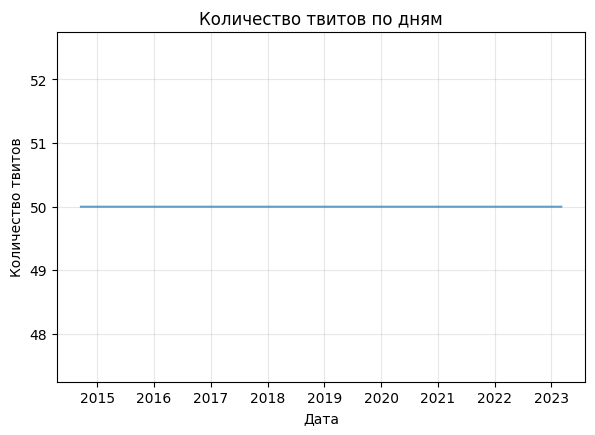

In [ ]:
plt.figure(figsize=(15, 10))

# 1-ый график. Визуализация дата - количество твитов
plt.subplot(2, 2, 1)
plt.plot(tweet_counts['date'], tweet_counts['count'], marker='', linestyle='-', alpha=0.7)
plt.title('Количество твитов по дням')
plt.xlabel('Дата')
plt.ylabel('Количество твитов')
plt.grid(True, alpha=0.3)

(array([16071., 16436., 16801., 17167., 17532., 17897., 18262., 18628.,
        18993., 19358.]),
 [Text(16071.0, 0, '2014'),
  Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023')])

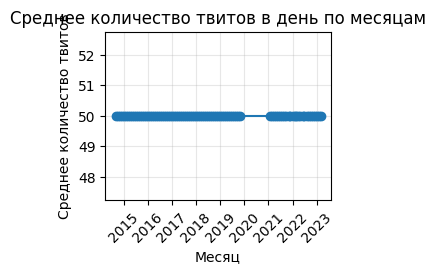

In [ ]:
# 2-ой график. Среднее количество твитов по месяцам
plt.subplot(2, 2, 2)
plt.plot(monthly_avg['year_month'], monthly_avg['count'], marker='o', linestyle='-')
plt.title('Среднее количество твитов в день по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Среднее количество твитов')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


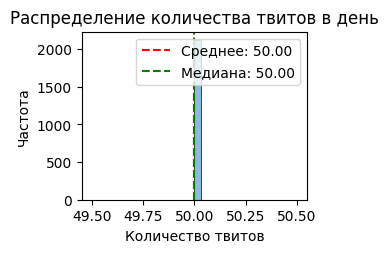

In [ ]:
# 3-ий график. Распределение количества твитов
plt.subplot(2, 2, 3)
sns.histplot(tweet_counts['count'], bins=30, kde=True)
plt.axvline(tweet_counts['count'].mean(), color='red', linestyle='--',
           label=f'Среднее: {tweet_counts["count"].mean():.2f}')
plt.axvline(tweet_counts['count'].median(), color='green', linestyle='--',
           label=f'Медиана: {tweet_counts["count"].median():.2f}')
plt.title('Распределение количества твитов в день')
plt.xlabel('Количество твитов')
plt.ylabel('Частота')
plt.legend()


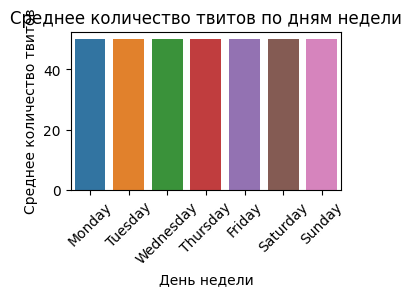

In [ ]:
# 4-ый график. Среднее количество твитов по дням недели
plt.subplot(2, 2, 4)
sns.barplot(x='day_of_week', y='count', data=dow_avg)
plt.title('Среднее количество твитов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Среднее количество твитов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

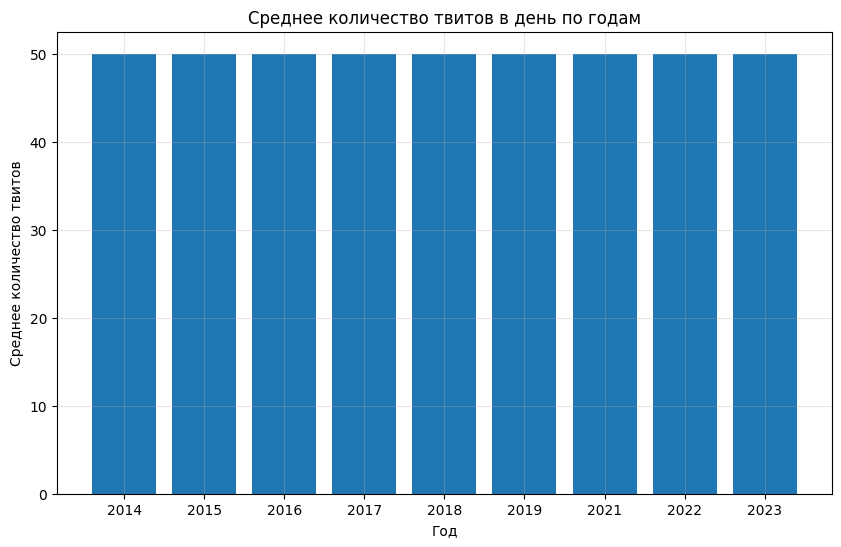

In [ ]:
# 5-ый график. Тренд по годам
tweet_counts['year'] = tweet_counts['date'].dt.year
yearly_avg = tweet_counts.groupby('year')['count'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(yearly_avg['year'].astype(str), yearly_avg['count'])
plt.title('Среднее количество твитов в день по годам')
plt.xlabel('Год')
plt.ylabel('Среднее количество твитов')
plt.grid(True, alpha=0.3)
plt.show()

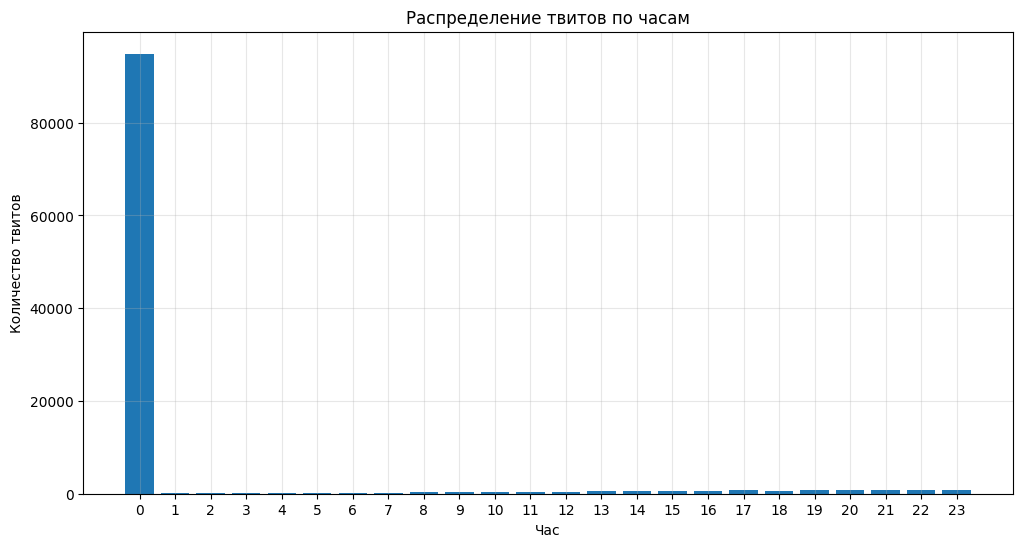

In [ ]:
# 6-ой график. Некоторые данные содержат точное время. Проанализируем распределение по часам.
if 'time' in df.columns and df['time'].notna().any():
    df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S', errors='coerce').dt.hour
    hourly_counts = df.groupby('hour').size().reset_index(name='count')

    plt.figure(figsize=(12, 6))
    plt.bar(hourly_counts['hour'], hourly_counts['count'])
    plt.title('Распределение твитов по часам')
    plt.xlabel('Час')
    plt.ylabel('Количество твитов')
    plt.xticks(range(24))
    plt.grid(True, alpha=0.3)
    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


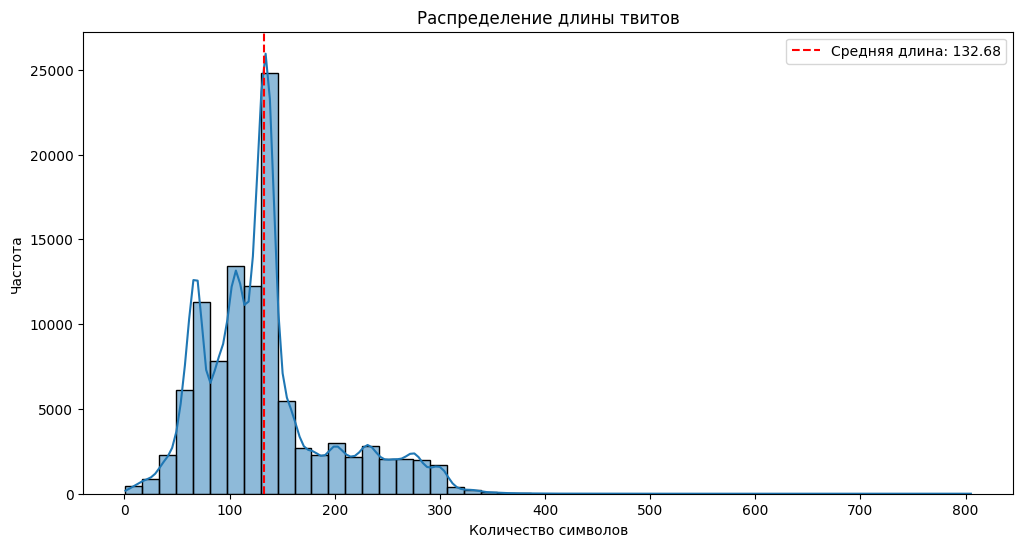

In [ ]:
# 7-ой график. Количестов символов в твите
df['tweet_length'] = df['content'].str.len()
plt.figure(figsize=(12, 6))
sns.histplot(df['tweet_length'].dropna(), bins=50, kde=True)
plt.axvline(df['tweet_length'].mean(), color='red', linestyle='--',
           label=f'Средняя длина: {df["tweet_length"].mean():.2f}')
plt.title('Распределение длины твитов')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.legend()
plt.show()